# Logistic Regression

### Linear Classifier

A linear classifier computes the score of one of $K$ classes as a weighted sum of all of its  values across all $d$ features. The general form to calculate the score is:

$$
f(x_i,W,b)=Wx_i+b,
$$

where $x_i$ is the $d-$dimensional feature vector with a known or unknown label $y_i$. The matrix $W$ (of size [K x D]), and the vector $b$ (of size [K x 1]) are the parameters of the function. The parameters in W are often called the weights, and b is called the bias vector because it influences the output scores.

Consider an example of mapping an image to class scores. For the sake of visualization, we assume the image only has 4 pixels (4 monochrome pixels, we are not considering color channels in this example for brevity), and that we have 3 classes (red (cat), green (dog), blue (ship) class). (Clarification: in particular, the colors here simply indicate 3 classes and are not related to the RGB channels.) We stretch the image pixels into a column and perform matrix multiplication to get the scores for each class. Note that this particular set of weights W is not good at all: the weights assign our cat image a very low cat score. In particular, this set of weights seems convinced that it's looking at a dog.

![demo](https://cs231n.github.io/assets/imagemap.jpg)

### Logistic Regression

In the linear classifier we defined a function from the feature vectors to class scores, which was parameterized by a set of weights $W$. Moreover, we saw that we don't have control over the data $(x_i,y_i)$ (it is fixed and given), but we do have control over these weights and we want to set them so that the predicted class scores are consistent with the ground truth labels in the training data.

For example, going back to the example image of a cat and its scores for the classes "cat", "dog" and "ship", we saw that the particular set of weights in that example was not very good at all: We fed in the pixels that depict a cat but the cat score came out very low (-96.8) compared to the other classes (dog score 437.9 and ship score 61.95). We are going to measure our unhappiness with outcomes such as this one with a loss function (or sometimes also referred to as the cost function or the objective). Intuitively, the loss will be high if we're doing a poor job of classifying the training data, and it will be low if we're doing well.

In Logistic Regression, or the Softmax classifier the loss function is calculated based on the normalized probability of the correct labels. More specifically, the function mapping $f(x_i;W)=Wx_i$ is interpreted as these scores as the unnormalized log probabilities for each class. 

Looking at the expression, we see that

$$
P(y_i \mid x_i; W) = \frac{e^{f_{y_i}}}{\sum_j e^{f_j} }
$$

can be interpreted as the (normalized) probability assigned to the correct label \\(y_i\\) given the feature vector \\(x_i\\) and parameterized by \\(W\\). To see this, remember that the Logistic Regression classifier interprets the scores inside the output vector \\(f\\) as the unnormalized log probabilities. Exponentiating these quantities therefore gives the (unnormalized) probabilities, and the division performs the normalization so that the probabilities sum to one. 

### Loss Function

The loss function for Logistic Regression, a log-likelihood loss, will have the following form:

$$
L_i = -\log{P(y_i|x_i;W)} = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}
$$

where we are using the notation \\(f_j\\) to mean the $j$-th element of the vector of class scores \\(f\\). The full loss for the dataset is the mean of \\(L_i\\) over all training examples. Some times, to control overfitting, the full loss function will be coupled with a regularization term \\(R(W)\\). The function \\(f_j(z) = \frac{e^{z_j}}{\sum_k e^{z_k}} \\) is called the **softmax function**: It takes a vector of arbitrary real-valued scores (in \\(z\\)) and squashes it to a vector of values between zero and one that sum to one. The full cross-entropy loss that involves the softmax function might look scary if you're seeing it for the first time but it is relatively easy to motivate.

In the probabilistic interpretation, we are therefore minimizing the negative log likelihood of the correct class, which can be interpreted as performing *Maximum Likelihood Estimation* (MLE).

#### Gradient Decent

The derivative of $L_i$ with respect to the $k$th weight vectorcan be calculated as follows:

- If $y_i = k$:

$$
\frac{\partial L_i}{W_k} = (P(y_i|x_i;W) - 1)x_i
$$

- If $y_i \neq k$:

$$
\frac{\partial L_i}{W_k} = P(k|x_i;W)x_i
$$

In the program, an indicator function, or judge function $I(y_i,k)$ could be employed to simplify the code.

In [2]:
from __future__ import division
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
class LR(object):
    def __init__(self, d, K):
        self.K = int(K) # K classes
        self.d = int(d) # d dimensions
        self.beta = np.random.rand(K,d)

    def prb(self, x, k):
        g = lambda k: np.exp(self.beta[k,:].dot(x))
        return g(k) / sum(map(g, range(self.K)))

    def predict(self, x):
        prob = map(lambda k: self.prb(x, k), range(self.K))
        return prob.index(max(prob))

    def judge(self, y, k):
        return int(y) == int(k)

    def score(self, data, labels):
        err = 0
        for (x,y) in zip(data, labels):
            p = self.predict(x)
            err += (p!=y)
        return 1 - err / len(data)

    def train(self, data, labels):
        """
        Gradient Decent
        """
        alpha = 1e-3
        iters = 0
        num = 100
        while iters < num:
            iters += 1
            for k in range(self.K):
                s = map(lambda (x,y): (self.prb(x, k) - self.judge(y, k)) * x, zip(data, labels))
                step = np.sum(s, axis=0)
                self.beta[k,:] -= alpha * step

#### Test Function

In [4]:
def test():
    data = datasets.load_iris()
    X = data.data[:100,:2]
    X = np.hstack((X, np.ones((100,1))))
    y = data.target[:100]
    """ raw data plot """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X[:50,0], X[:50,1], color="black", marker="s", label="Setosa")
    ax.scatter(X[50:,0], X[50:,1], color="red", marker="s", label="Versicolor")
    """ classifier """
    clf = LR(d=3, K=2)
    clf.train(X, y)
    """ decision region """
    for ix in np.arange(4.0, 7.5, 0.1):
        for iy in np.arange(1.5, 5.0, 0.1):
            pred = clf.predict(np.array([ix,iy,1]))
            if pred == y[0]:
                ax.scatter(ix, iy, color="green", alpha=0.2)
            else:
                ax.scatter(ix, iy, color="blue", alpha=0.2)
    ax.set_xlim(4.0, 7.5)
    ax.set_ylim(1.5, 5.0)
    ax.set_xlabel("Sepal Length")
    ax.set_ylabel("Sepal Width")
    ax.legend()
    ax.grid()
    plt.show()

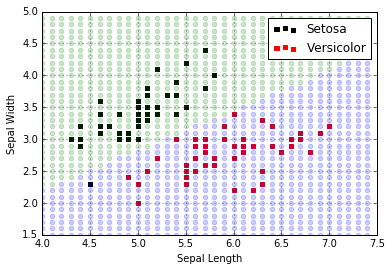

In [5]:
test()

### Other Notes

 - [1]. In the binary classification case, LR could be simplified significantly. But mathetically all the various forms are equivalent.
 
 - [2]. There are many interpretations of LR (and its loss function). For example, the cross-entropy point of view.